In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
from sklearn import linear_model, datasets
from sklearn.impute import SimpleImputer
from matplotlib.colors import LinearSegmentedColormap
import gzip
from Bio import SeqIO
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns
from scipy import stats
from my_functions import *
# from matplotlib_venn import venn2, venn2_circles
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.inspection import permutation_importance
import math
from os.path import exists
import pickle

#from Bio.SeqUtils import CodonUsage as CU
#from CAI import CAI, relative_adaptiveness

In [2]:
# Load the normalized moby data file from Auguste
moby = pd.read_csv('datasets/Robinson_MoBylogFC.csv', sep=",", index_col=0)
moby.head()

,BC187_YPD_Avg_log2_Fitness_Score,BC187_FDR,BY4743_YPD_Avg_log2_Fitness_Score,BY4743_FDR,DBVPG1373_YPD_Avg_log2_Fitness_Score,DBVPG1373_FDR,NCYC3290_YPD_Avg_log2_Fitness_Score,NCYC3290_FDR,Y12_YPD_Avg_log2_Fitness_Score,Y12_FDR,...,YJM1592_YPD_Avg_log2_Fitness_Score,YJM1592_FDR,YJM978_YPD_Avg_log2_Fitness_Score,YJM978_FDR,YPS128_YPD_Avg_log2_Fitness_Score,YPS128_FDR,YPS163_YPD_Avg_log2_Fitness_Score,YPS163_FDR,YPS606_YPD_Avg_log2_Fitness_Score,YPS606_FDR
UID,,,,,,,,,,,,,,,,,,,,,
YLR248W,0.121845,0.589700,-0.318184,2.873703e-02,-0.960879,2.723830e-04,-1.367972,4.312082e-03,-3.865272,3.310000e-09,...,-0.429359,0.329717,-2.282613,8.810000e-07,-3.144128,4.240000e-07,-0.751203,1.652920e-04,-2.655671,0.001311
YJL080C,0.103438,0.569848,-0.750228,1.180000e-06,NaN,NaN,-2.694566,6.810000e-07,-3.671277,1.750000e-22,...,-0.382051,0.195030,-0.949060,1.733745e-03,-1.296229,5.280450e-04,-0.561432,3.281660e-04,-2.402641,0.000772
YGL146C,0.060068,0.691126,0.352109,1.350090e-04,-0.245377,1.208888e-02,-1.082683,4.580000e-05,-0.346361,1.629129e-01,...,-0.271693,0.259462,0.543658,2.473955e-03,-0.703407,2.588730e-02,-0.802944,1.330000e-07,-1.877977,0.001299
YOR198C,-0.101255,0.596991,-0.256964,6.270093e-02,-2.043087,3.730000e-09,-1.782251,1.350000e-08,-1.248494,5.230000e-06,...,-0.694586,0.000448,-0.769389,4.392142e-03,-0.859545,1.492778e-02,-0.604941,3.500000e-06,NaN,NaN
YER123W,0.020034,0.906217,-1.313831,7.160000e-20,-2.178763,1.800000e-28,-3.693308,4.130000e-11,-3.172277,4.370000e-26,...,0.035331,0.909215,0.016955,9.476178e-01,-1.080013,5.790000e-05,-1.957887,1.150000e-22,-1.515739,0.001327


In [3]:
# commonly toxic genes
common = pd.read_csv('datasets/Robinson_moby_commonlytoxic.txt', sep='\t', index_col=0)

In [4]:
moby['Label'] = 0
moby.loc[moby.index.isin(list(common.index)), 'Label'] = 1

In [5]:
moby.Label.sum()

431

In [6]:
DF = moby[['Label']]

In [7]:
DF

,Label
UID,
YLR248W,1
YJL080C,1
YGL146C,0
YOR198C,1
YER123W,1
...,...
YGL151W,0
YPL186C,0
YDL027C,0


# Loading features used by Dee (Robinson, Elife)
NB: the features weren't calculated for YPS1009 and I have very little details on some on these features 

In [8]:
Dee_feat = pd.read_csv('datasets/Machine_learning_YeastGeneFeatures_amino_acid_counts_removed_revised_11_30_20.csv', usecols = ['gene','geneLen', 'GC', 'median_IUPRED', '5UTR_PARS_RNAstructure',
       'CDS_PARS_RNAstructure', '3UTR_PARS_RNAstructure', '%AA_A', '%AA_C', '%AA_D', '%AA_E', '%AA_F', '%AA_G', '%AA_H', '%AA_I', '%AA_K', '%AA_L',
       '%AA_M', '%AA_N', '%AA_P', '%AA_Q', '%AA_R', '%AA_S', '%AA_T', '%AA_V', '%AA_W', '%AA_Y', '%Helical', '%Proteinturn', '%Beta-sheet'], index_col=0, low_memory=False)

In [9]:
Dee_feat.head()

,geneLen,GC,median_IUPRED,5UTR_PARS_RNAstructure,CDS_PARS_RNAstructure,3UTR_PARS_RNAstructure,%AA_A,%AA_C,%AA_D,%AA_E,...,%AA_Q,%AA_R,%AA_S,%AA_T,%AA_V,%AA_W,%AA_Y,%Helical,%Proteinturn,%Beta-sheet
gene,,,,,,,,,,,,,,,,,,,,,
Q0010,387,23.7726,0.0004,NaN,NaN,NaN,0.0000,0.0078,0.0233,0.0078,...,0.0000,0.0078,0.0620,0.0388,0.0620,0.0155,0.1705,0.5969,0.2248,0.1783
Q0017,162,29.0123,0.0697,NaN,NaN,NaN,0.0185,0.0185,0.0185,0.0000,...,0.0000,0.0741,0.0185,0.1296,0.0370,0.0000,0.0926,0.3704,0.2407,0.1667
Q0032,291,11.3402,0.0004,NaN,NaN,NaN,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0103,0.0515,0.0722,0.0103,0.0412,0.1753,0.4948,0.1649,0.2887
Q0045,1605,29.9065,0.0064,NaN,NaN,NaN,0.0822,0.0019,0.0243,0.0168,...,0.0168,0.0168,0.0804,0.0579,0.0710,0.0187,0.0449,0.4355,0.2579,0.2654
Q0050,2505,24.9501,0.1759,NaN,NaN,NaN,0.0371,0.0156,0.0407,0.0347,...,0.0168,0.0551,0.0539,0.0731,0.0491,0.0096,0.0467,0.3090,0.2335,0.2251


In [10]:
DF = DF.join(Dee_feat)

# Group AA% based on aa caracteristic

In [11]:
DF['Acidic AA%'] = DF[['%AA_D', '%AA_E']].sum(axis=1)
DF['Basic AA%'] = DF[['%AA_K', '%AA_R', '%AA_H']].sum(axis=1)
DF['Polar AA%'] = DF[['%AA_S', '%AA_T', '%AA_C', '%AA_Y', '%AA_N', '%AA_Q']].sum(axis=1)
DF['Hydrophobic AA%'] = DF[['%AA_A', '%AA_V', '%AA_L', '%AA_I', 
                          '%AA_M', '%AA_F', '%AA_W', '%AA_Y']].sum(axis=1)
DF['Charged AA%'] = DF[['%AA_D', '%AA_E', '%AA_K', '%AA_R', '%AA_H']].sum(axis=1)

# Add BioGrid Features 

In [12]:
bioG = pd.read_csv('datasets/BioGrid4.4.217_features_count.csv', index_col=0)

In [13]:
DF = DF.join(bioG)

In [14]:
DF

,Label,geneLen,GC,median_IUPRED,5UTR_PARS_RNAstructure,CDS_PARS_RNAstructure,3UTR_PARS_RNAstructure,%AA_A,%AA_C,%AA_D,...,%Proteinturn,%Beta-sheet,Acidic AA%,Basic AA%,Polar AA%,Hydrophobic AA%,Charged AA%,number of physical interaction,number of positive genetic interaction,number of negative genetic interaction
UID,,,,,,,,,,,,,,,,,,,,,
YLR248W,1,1833.0,40.3710,0.3740,0.118182,0.307633,0.048966,0.0507,0.0082,0.0851,...,0.2324,0.2209,0.1620,0.1506,0.2652,0.3387,0.3126,73.0,3.0,6.0
YJL080C,1,3669.0,39.6293,0.3631,0.398689,0.425746,-0.016341,0.0736,0.0033,0.0540,...,0.2469,0.2527,0.1521,0.1496,0.2569,0.3664,0.3017,177.0,NaN,NaN
YGL146C,0,936.0,41.9872,0.1528,NaN,NaN,NaN,0.0449,0.0128,0.0545,...,0.2660,0.2404,0.1058,0.1186,0.3012,0.4135,0.2244,2.0,2.0,24.0
YOR198C,1,1413.0,37.6504,0.4582,0.000000,0.314086,0.049900,0.0467,0.0000,0.0743,...,0.1677,0.2590,0.1783,0.2166,0.2591,0.3143,0.3949,18.0,31.0,38.0
YER123W,1,1575.0,36.8889,0.3215,NaN,NaN,NaN,0.0457,0.0248,0.0648,...,0.2838,0.1733,0.1048,0.1638,0.3485,0.3296,0.2686,22.0,4.0,31.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
YGL151W,0,3399.0,34.9515,0.0985,NaN,NaN,NaN,0.0432,0.0097,0.0618,...,0.2410,0.2524,0.1298,0.1103,0.3203,0.4121,0.2401,24.0,18.0,118.0
YPL186C,0,915.0,40.2186,0.7982,NaN,NaN,NaN,0.0492,0.0000,0.0885,...,0.2787,0.2426,0.2262,0.1279,0.2951,0.2590,0.3541,NaN,NaN,NaN
YDL027C,0,1263.0,35.7878,0.0888,NaN,NaN,NaN,0.0333,0.0071,0.0285,...,0.2542,0.1995,0.0760,0.1592,0.2969,0.4134,0.2352,NaN,NaN,NaN


# String PPI

In [15]:
string = pd.read_csv('datasets/string/4932.protein.physical.links.v12.0.txt', sep=' ')
string['combined_score'] = string['combined_score']/1000
string['protein1'] = string['protein1'].str.replace('4932.', '')
string['protein2'] = string['protein2'].str.replace('4932.', '')
string05 = string[string['combined_score'] > 0.5]
string08 = string[string['combined_score'] > 0.8]

<Axes: >

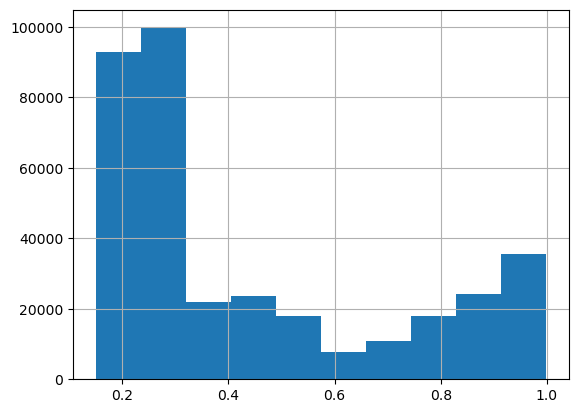

In [16]:
# That's a weird distribution
string['combined_score'].hist()

In [17]:
def ppi_to_nb_interaction(string, name):
    prot = set(string['protein1'])
    nb_int = []
    for p in prot:
        tmp = string[string['protein1'] == p]
        nb_int.append(tmp.shape[0])
        
    return pd.DataFrame({'gene': list(prot), name: nb_int})

In [18]:
nbppi = ppi_to_nb_interaction(string, 'number of ppi, all')
nbppi = nbppi.set_index('gene')
DF = DF.join(nbppi)

In [19]:
string025 = string[string['combined_score'] >= 0.25]
nbppi025 = ppi_to_nb_interaction(string025, 'number of ppi, score >= 0.25')
nbppi025 = nbppi025.set_index('gene')
DF = DF.join(nbppi025)

In [20]:
nbppi05 = ppi_to_nb_interaction(string05, 'number of ppi, score > 0.5')
nbppi05 = nbppi05.set_index('gene')

In [21]:
nbppi08 = ppi_to_nb_interaction(string08, 'number of ppi, score > 0.8')
nbppi08 = nbppi08.set_index('gene')

In [22]:
DF = DF.join(nbppi05)
DF = DF.join(nbppi08)

In [23]:
string095 = string[string['combined_score'] >= 0.95]
nbppi095 = ppi_to_nb_interaction(string095, 'number of ppi, score >= 0.95')
nbppi095 = nbppi095.set_index('gene')
DF = DF.join(nbppi095)

In [24]:
DF.columns

Index(['Label', 'geneLen', 'GC', 'median_IUPRED', '5UTR_PARS_RNAstructure',
       'CDS_PARS_RNAstructure', '3UTR_PARS_RNAstructure', '%AA_A', '%AA_C',
       '%AA_D', '%AA_E', '%AA_F', '%AA_G', '%AA_H', '%AA_I', '%AA_K', '%AA_L',
       '%AA_M', '%AA_N', '%AA_P', '%AA_Q', '%AA_R', '%AA_S', '%AA_T', '%AA_V',
       '%AA_W', '%AA_Y', '%Helical', '%Proteinturn', '%Beta-sheet',
       'Acidic AA%', 'Basic AA%', 'Polar AA%', 'Hydrophobic AA%',
       'Charged AA%', 'number of physical interaction',
       'number of positive genetic interaction',
       'number of negative genetic interaction', 'number of ppi, all',
       'number of ppi, score >= 0.25', 'number of ppi, score > 0.5',
       'number of ppi, score > 0.8', 'number of ppi, score >= 0.95'],
      dtype='object')

In [25]:
DF[['number of physical interaction',
       'number of positive genetic interaction',
       'number of negative genetic interaction', 'number of ppi, score > 0.5',
       'number of ppi, score > 0.8', 'number of ppi, score >= 0.95']] = DF[['number of physical interaction',
       'number of positive genetic interaction',
       'number of negative genetic interaction', 'number of ppi, score > 0.5',
       'number of ppi, score > 0.8', 'number of ppi, score >= 0.95']].fillna(0) 

<Axes: xlabel='number of physical interaction', ylabel='number of ppi, score >= 0.95'>

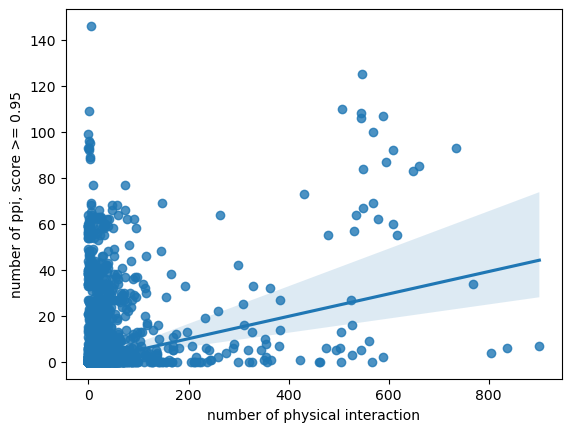

In [26]:
sns.regplot(data=DF, x='number of physical interaction', y='number of ppi, score >= 0.95', robust=True)

# Now, add the YPS1009 features I computed before
### Transcriptome

In [27]:
# log2 tmm, mean of the 2 Euploid WT replicates
rna = pd.read_csv('datasets/yps1009_rnaseq_tmm_euploidWT_mean.txt', sep= '\t' ,index_col=0)
rna.rename(columns={'Euploid mean': "RNAseq Eupl"}, inplace=True)

In [28]:
DF = DF.join(rna)

# logFC disomes only and logFC w/o disomes 

In [29]:
fc = pd.read_csv('datasets/QLF_disomes_WT_FC_dis_vs_other.csv', index_col=0)

In [30]:
fc['rna FC - other'] = fc['logFC'] - fc['FC - dis']

In [31]:
fc.rename(columns={'logFC': 'rna logFC'}, inplace=True)

In [32]:
fc.columns

Index(['gene', 'Chromosome', 'orf_classification', 'NAME', '1', '2', '3', '4',
       '5', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16',
       'rna logFC', 'FC - dis', 'rna FC - other'],
      dtype='object')

In [33]:
DF = DF.join(fc[['rna logFC', 'rna FC - other']])

In [34]:
DF

,Label,geneLen,GC,median_IUPRED,5UTR_PARS_RNAstructure,CDS_PARS_RNAstructure,3UTR_PARS_RNAstructure,%AA_A,%AA_C,%AA_D,...,number of positive genetic interaction,number of negative genetic interaction,"number of ppi, all","number of ppi, score >= 0.25","number of ppi, score > 0.5","number of ppi, score > 0.8","number of ppi, score >= 0.95",RNAseq Eupl,rna logFC,rna FC - other
UID,,,,,,,,,,,,,,,,,,,,,
YAL001C,0,3483.0,37.1232,0.2541,NaN,NaN,NaN,0.0448,0.0060,0.0680,...,13.0,74.0,41.0,38.0,11.0,9.0,5.0,4.360343,0.846386,0.883887
YAL002W,0,3825.0,37.1765,0.0719,NaN,NaN,NaN,0.0392,0.0204,0.0541,...,41.0,217.0,21.0,18.0,9.0,8.0,5.0,4.821862,0.796230,0.882032
YAL003W,1,621.0,44.6055,0.3494,-0.715385,1.217176,0.303319,0.1546,0.0048,0.1063,...,1.0,9.0,49.0,42.0,5.0,4.0,4.0,10.931778,0.732577,1.049997
YAL005C,1,1929.0,44.0643,0.3807,0.660469,1.003508,-0.125213,0.0933,0.0047,0.0762,...,0.0,0.0,516.0,205.0,25.0,11.0,2.0,7.277398,1.250652,-0.380706
YAL007C,0,648.0,37.0370,0.0632,0.536046,0.494137,-0.035873,0.0741,0.0093,0.0556,...,4.0,34.0,61.0,55.0,16.0,4.0,1.0,6.559462,0.693758,0.868228
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
YPR192W,0,918.0,51.0893,0.0281,NaN,NaN,NaN,0.1307,0.0261,0.0359,...,0.0,2.0,5.0,1.0,0.0,0.0,0.0,1.552950,2.574880,1.047717
YPR196W,0,1413.0,38.8535,0.0414,NaN,NaN,NaN,0.0467,0.0382,0.0701,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,3.334543,1.349454,1.512571
YPR199C,0,885.0,38.9831,0.1852,0.130769,0.075395,0.073654,0.0508,0.0271,0.0441,...,2.0,11.0,29.0,4.0,1.0,0.0,0.0,3.420697,1.590873,1.371615


### Interactome

interactions_df = pd.read_csv('datasets/interactome_sgd.csv')
Nb_interactors = pd.DataFrame(interactions_df['Interaction.participant1.secondaryIdentifier'].value_counts())
Nb_interactors = Nb_interactors.rename(columns={'Interaction.participant1.secondaryIdentifier' :'Number of interactor'})

DF = DF.join(Nb_interactors)

In [35]:
DF

,Label,geneLen,GC,median_IUPRED,5UTR_PARS_RNAstructure,CDS_PARS_RNAstructure,3UTR_PARS_RNAstructure,%AA_A,%AA_C,%AA_D,...,number of positive genetic interaction,number of negative genetic interaction,"number of ppi, all","number of ppi, score >= 0.25","number of ppi, score > 0.5","number of ppi, score > 0.8","number of ppi, score >= 0.95",RNAseq Eupl,rna logFC,rna FC - other
UID,,,,,,,,,,,,,,,,,,,,,
YAL001C,0,3483.0,37.1232,0.2541,NaN,NaN,NaN,0.0448,0.0060,0.0680,...,13.0,74.0,41.0,38.0,11.0,9.0,5.0,4.360343,0.846386,0.883887
YAL002W,0,3825.0,37.1765,0.0719,NaN,NaN,NaN,0.0392,0.0204,0.0541,...,41.0,217.0,21.0,18.0,9.0,8.0,5.0,4.821862,0.796230,0.882032
YAL003W,1,621.0,44.6055,0.3494,-0.715385,1.217176,0.303319,0.1546,0.0048,0.1063,...,1.0,9.0,49.0,42.0,5.0,4.0,4.0,10.931778,0.732577,1.049997
YAL005C,1,1929.0,44.0643,0.3807,0.660469,1.003508,-0.125213,0.0933,0.0047,0.0762,...,0.0,0.0,516.0,205.0,25.0,11.0,2.0,7.277398,1.250652,-0.380706
YAL007C,0,648.0,37.0370,0.0632,0.536046,0.494137,-0.035873,0.0741,0.0093,0.0556,...,4.0,34.0,61.0,55.0,16.0,4.0,1.0,6.559462,0.693758,0.868228
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
YPR192W,0,918.0,51.0893,0.0281,NaN,NaN,NaN,0.1307,0.0261,0.0359,...,0.0,2.0,5.0,1.0,0.0,0.0,0.0,1.552950,2.574880,1.047717
YPR196W,0,1413.0,38.8535,0.0414,NaN,NaN,NaN,0.0467,0.0382,0.0701,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,3.334543,1.349454,1.512571
YPR199C,0,885.0,38.9831,0.1852,0.130769,0.075395,0.073654,0.0508,0.0271,0.0441,...,2.0,11.0,29.0,4.0,1.0,0.0,0.0,3.420697,1.590873,1.371615


### Proteomics data
The advantage is that it's YPS1009, the disadvantage is that it doesn't cover the whole genome.
I would argue that low abundant proteins that are not picked up by mass spec may not influence the RG so much.
I could search for deeper dataset

In [36]:
ms = pd.read_csv('datasets/elifeHose_Proteinabundance_normalize__WT.csv', sep=',', index_col=0)
# replace zero by nan because I don't want zeros to lower my mean
ms.replace(0, np.nan, inplace=True)
ms_mean = pd.DataFrame(ms.mean(axis=1))
ms_mean.rename(columns={0: "MS mean"}, inplace=True)
# log2 transformation 
ms_mean['log2(MS)'] = ms_mean['MS mean'] +1
ms_mean['log2(MS)'] = np.log2(ms_mean['log2(MS)'])

# join to DF
DF = DF.join(ms_mean)
# imputation (Perseus style)
# create a series of values with a Gaussian distribution to impute missing values.
Width = 0.3
Down_shift = 1.6

mean = np.mean(DF['log2(MS)'])
stddev = np.std(DF['log2(MS)'])

m = mean - Down_shift*stddev
s = stddev* Width
r = np.random.normal(m, s, DF['log2(MS)'].isnull().sum())

# Impute values from the generated normal distribution
imputed_log2mean = list(DF['log2(MS)'])
y = 0
for x in range(len(imputed_log2mean)):
    if math.isnan(imputed_log2mean[x]) == True:
        imputed_log2mean[x] = r[y]
        y+=1
DF['Imputed log2(MS)'] = imputed_log2mean

In [37]:
DF

,Label,geneLen,GC,median_IUPRED,5UTR_PARS_RNAstructure,CDS_PARS_RNAstructure,3UTR_PARS_RNAstructure,%AA_A,%AA_C,%AA_D,...,"number of ppi, score >= 0.25","number of ppi, score > 0.5","number of ppi, score > 0.8","number of ppi, score >= 0.95",RNAseq Eupl,rna logFC,rna FC - other,MS mean,log2(MS),Imputed log2(MS)
UID,,,,,,,,,,,,,,,,,,,,,
YAL001C,0,3483.0,37.1232,0.2541,NaN,NaN,NaN,0.0448,0.0060,0.0680,...,38.0,11.0,9.0,5.0,4.360343,0.846386,0.883887,8.404233e+07,26.324613,26.324613
YAL002W,0,3825.0,37.1765,0.0719,NaN,NaN,NaN,0.0392,0.0204,0.0541,...,18.0,9.0,8.0,5.0,4.821862,0.796230,0.882032,1.321033e+07,23.655164,23.655164
YAL003W,1,621.0,44.6055,0.3494,-0.715385,1.217176,0.303319,0.1546,0.0048,0.1063,...,42.0,5.0,4.0,4.0,10.931778,0.732577,1.049997,6.330067e+10,35.881502,35.881502
YAL005C,1,1929.0,44.0643,0.3807,0.660469,1.003508,-0.125213,0.0933,0.0047,0.0762,...,205.0,25.0,11.0,2.0,7.277398,1.250652,-0.380706,1.386733e+10,33.690971,33.690971
YAL007C,0,648.0,37.0370,0.0632,0.536046,0.494137,-0.035873,0.0741,0.0093,0.0556,...,55.0,16.0,4.0,1.0,6.559462,0.693758,0.868228,3.571567e+08,28.411982,28.411982
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
YPR192W,0,918.0,51.0893,0.0281,NaN,NaN,NaN,0.1307,0.0261,0.0359,...,1.0,0.0,0.0,0.0,1.552950,2.574880,1.047717,4.186233e+07,25.319149,25.319149
YPR196W,0,1413.0,38.8535,0.0414,NaN,NaN,NaN,0.0467,0.0382,0.0701,...,1.0,0.0,0.0,0.0,3.334543,1.349454,1.512571,NaN,NaN,23.803377
YPR199C,0,885.0,38.9831,0.1852,0.130769,0.075395,0.073654,0.0508,0.0271,0.0441,...,4.0,1.0,0.0,0.0,3.420697,1.590873,1.371615,NaN,NaN,24.026919


### Translation rate fitting

From that article. fancy analysis. usefull to look at it because they also do linear modelling to figure out important factors for translation rate.

However the protein synthesis rate is obtained for 1106 protein only.

In [38]:
Trans = pd.read_csv('datasets/pnas.1817299116.sd01.tsv', sep='\t')
psynth = Trans[['ensembl_gene_id', 'protein_synthesis_rate' ,'real_protein_synthesis_rate']]
psynth = psynth.set_index('ensembl_gene_id')

In [39]:
psynth.shape

(1106, 2)

In [40]:
DF = DF.join(psynth)

### Translation rate form different dataset (from Ribosome profilling )

Table S1 from that paper: 
The extent of ribosome queuing in budding yeast
Alon Diament, Anna Feldman, Elisheva Schochet, Martin Kupiec, Yoav Arava, Tamir Tuller
https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1005951#sec017

In [41]:
Ribo = pd.read_csv('datasets/pcbi1005951s002.csv', sep=',', index_col=0)

In [42]:
Ribo.shape

(5450, 7)

In [43]:
for c in Ribo.columns:
    Ribo.rename(columns={c: "Ribo_profilling_" + c}, inplace=True)

In [44]:
DF = DF.join(Ribo[['Ribo_profilling_init_rate', 'Ribo_profilling_ribo_num',
                   'Ribo_profilling_trans_rate', 'Ribo_profilling_trans_time', 'Ribo_profilling_delay_time']])

### My IDR calculation
See the features_computation_for_multi_linear_models jupyter notebook for computation detail 

In [45]:
IDR = pd.read_csv('datasets/IDRratios.csv', index_col=0)

In [46]:
DF = DF.join(IDR)

In [47]:
DF.rename(columns={'GC': "GC_content"}, inplace=True)

# Protein localization and abundance from the Weizmann 
http://www.weizmann.ac.il/molgen/loqate/downloads

In [48]:
loc_df = pd.read_excel('datasets/proteomesummarylatestversion.xlsx')

C:\Users\user\anaconda3\lib\site-packages\openpyxl\worksheet\_read_only.py:79: UserWarning: Unknown extension is not supported and will be removed
  for idx, row in parser.parse():


In [49]:
loc_df.columns

Index(['ORF', 'Gene', 'Description', 'Control Median', 'Control STD',
       'control Localization', 'DTT Median', 'DTT STD', 'DTT FoldChange',
       'Significance DTT', 'DTT Localization', 'H2O2 Median', 'H2O2 STD',
       'H2O2 FoldChange', 'Significance H2O2', 'H2O2 Localization',
       'Starvation Median', 'Starvation STD', 'Starvation FoldChange',
       'Significance Starvation ', 'Starvation Localization', 'Pup2-DAmP',
       'MA3 Median', 'MA3 STD', 'MA3 FoldChange', 'Significance MA3 ',
       'MA3 Localization'],
      dtype='object')

In [50]:
loc_df = loc_df[['ORF', 'Control Median', 'control Localization']]
loc_df.set_index("ORF", inplace = True)

In [51]:
loc_df.isna().sum()

Control Median          73
control Localization     0
dtype: int64

In [52]:
DF = DF.join(loc_df)

# GO categories 

# Proteins part of complex

Count in how many complex the protein was identified.
Datase CYC200(, manually curated complexes. https://academic.oup.com/nar/article/37/3/825/1073031

Dataset: https://wodaklab.org/cyc2008/

In [53]:
cyc = pd.read_csv('datasets/CYC2008_complex.txt', sep = '\t')

In [54]:
orf = cyc['ORF']
comp_dic = {}
for o in orf:
    if o in comp_dic:
        comp_dic[o] += 1
    else:
        comp_dic[o] = 1

In [55]:
compl = pd.DataFrame.from_dict(comp_dic, orient ='index') 

In [56]:
compl.value_counts()

1    1416
2     164
3      30
5       9
4       6
8       1
9       1
Name: count, dtype: int64

In [57]:
DF = DF.join(compl)

In [58]:
DF = DF.rename(columns={0: 'Number of complexe'})

In [59]:
DF['Number of complexe'] = DF['Number of complexe'].fillna(0)

# Ribosome pause scores 

https://www.nature.com/articles/s41586-021-04295-4#Sec17

In [60]:
stein = pd.read_csv('datasets/Stein2022.csv', index_col= 0)

In [61]:
genes = set(stein.index)
d0_pause_score = []
odds_ratio = []
for g in genes:
    temp = stein[stein.index == g]
    d0_pause_score.append(temp['WT D0 Pause Score'].sum())
    odds_ratio.append(temp['WT Odds Ratio'].sum())
    
    
# Calling DataFrame constructor after zipping
# both lists, with columns specified
stein = pd.DataFrame(list(zip(d0_pause_score, odds_ratio)),
               columns =['Sum d0 Pause Score', 'Sum Odds Ratio'], index = list(genes))

In [62]:
DF = DF.join(stein)

# From sequence, get di-codon count
leave out for now

def dinucleotide_count(seq):
    dic = {}
    di_n = 0
    for x in range(0, len(seq)-5,3):
        di_n +=1
        if seq[x:x+6] in dic:
            dic[seq[x:x+6]] +=1
        else:
            dic[seq[x:x+6]] = 1
    for key, value in dic.items():
        dic[key] = value/di_n
    return dic

seqs = list(sequences['sequence'])
res = []
for x in range(len(seqs)):
    dic = dinucleotide_count(seqs[x])
    res.append(dic)

dinucl = pd.DataFrame.from_records(res,index=sequences.index)

dinucl.fillna(0, inplace=True)
DF = DF.join(dinucl)

# Get codon counts

def codon_count(seq):
    dic = {}
    di_n = 0
    for x in range(0, len(seq)-2,3):
        di_n +=1
        if seq[x:x+3] in dic:
            dic[seq[x:x+3]] +=1
        else:
            dic[seq[x:x+3]] = 1
    for key, value in dic.items():
        dic[key] = value/di_n
    return dic

seqs = list(sequences['sequence'])
res = []
for x in range(len(seqs)):
    dic = codon_count(seqs[x])
    res.append(dic)

codon = pd.DataFrame.from_records(res,index=sequences.index)

codon.fillna(0, inplace=True)
DF = DF.join(codon)

In [63]:
# remove first row = empty vector
DF = DF.iloc[1: , :]

### Function to find Nan Value

In [64]:
def Nan_columns(df):
    l = pd.DataFrame(df.isna().sum())
    for ind, row in l.iterrows():
        if row[0] > 0:
            print(ind, row[0])

In [65]:
Nan_columns(DF)

geneLen 5
GC_content 5
median_IUPRED 8
5UTR_PARS_RNAstructure 1899
CDS_PARS_RNAstructure 1899
3UTR_PARS_RNAstructure 1899
%AA_A 5
%AA_C 5
%AA_D 5
%AA_E 5
%AA_F 5
%AA_G 5
%AA_H 5
%AA_I 5
%AA_K 5
%AA_L 5
%AA_M 5
%AA_N 5
%AA_P 5
%AA_Q 5
%AA_R 5
%AA_S 5
%AA_T 5
%AA_V 5
%AA_W 5
%AA_Y 5
%Helical 5
%Proteinturn 5
%Beta-sheet 5
number of ppi, all 75
number of ppi, score >= 0.25 120
RNAseq Eupl 157
rna logFC 297
rna FC - other 297
MS mean 1304
log2(MS) 1304
protein_synthesis_rate 3316
real_protein_synthesis_rate 3316
Ribo_profilling_init_rate 470
Ribo_profilling_ribo_num 470
Ribo_profilling_trans_rate 470
Ribo_profilling_trans_time 470
Ribo_profilling_delay_time 470
IDR ratio 5
Control Median 674
control Localization 623
Sum d0 Pause Score 3421
Sum Odds Ratio 3421


In [66]:
DF.columns[1:60]

Index(['geneLen', 'GC_content', 'median_IUPRED', '5UTR_PARS_RNAstructure',
       'CDS_PARS_RNAstructure', '3UTR_PARS_RNAstructure', '%AA_A', '%AA_C',
       '%AA_D', '%AA_E', '%AA_F', '%AA_G', '%AA_H', '%AA_I', '%AA_K', '%AA_L',
       '%AA_M', '%AA_N', '%AA_P', '%AA_Q', '%AA_R', '%AA_S', '%AA_T', '%AA_V',
       '%AA_W', '%AA_Y', '%Helical', '%Proteinturn', '%Beta-sheet',
       'Acidic AA%', 'Basic AA%', 'Polar AA%', 'Hydrophobic AA%',
       'Charged AA%', 'number of physical interaction',
       'number of positive genetic interaction',
       'number of negative genetic interaction', 'number of ppi, all',
       'number of ppi, score >= 0.25', 'number of ppi, score > 0.5',
       'number of ppi, score > 0.8', 'number of ppi, score >= 0.95',
       'RNAseq Eupl', 'rna logFC', 'rna FC - other', 'MS mean', 'log2(MS)',
       'Imputed log2(MS)', 'protein_synthesis_rate',
       'real_protein_synthesis_rate', 'Ribo_profilling_init_rate',
       'Ribo_profilling_ribo_num', 'Ribo_profil

# Add Introns 

I broke yeastmine by reinsalling anaconda, 
So I won't recompute this features, instead I'm reloading my earlier dataset.

In [67]:
introns = pd.read_csv('datasets/introns.tsv', sep='\t')

In [68]:
introns = introns.groupby('Gene.secondaryIdentifier').median(numeric_only=True)

In [69]:
DF = DF.join(introns)

In [70]:
DF = DF.rename(columns={'Gene.introns.length': 'Introns median length'})

In [71]:
DF

,Label,geneLen,GC_content,median_IUPRED,5UTR_PARS_RNAstructure,CDS_PARS_RNAstructure,3UTR_PARS_RNAstructure,%AA_A,%AA_C,%AA_D,...,Ribo_profilling_trans_rate,Ribo_profilling_trans_time,Ribo_profilling_delay_time,IDR ratio,Control Median,control Localization,Number of complexe,Sum d0 Pause Score,Sum Odds Ratio,Introns median length
YAL002W,0,3825.0,37.1765,0.0719,NaN,NaN,NaN,0.0392,0.0204,0.0541,...,0.024,321.702,2.411,0.016471,19.55,punctate,1.0,NaN,NaN,NaN
YAL003W,1,621.0,44.6055,0.3494,-0.715385,1.217176,0.303319,0.1546,0.0048,0.1063,...,NaN,NaN,NaN,0.178744,NaN,NaN,1.0,12.43,18.85,365.0
YAL005C,1,1929.0,44.0643,0.3807,0.660469,1.003508,-0.125213,0.0933,0.0047,0.0762,...,0.161,98.542,1.962,0.231726,18.27,below threshold,0.0,66.37,32.94,NaN
YAL007C,0,648.0,37.0370,0.0632,0.536046,0.494137,-0.035873,0.0741,0.0093,0.0556,...,0.139,49.842,2.755,0.000000,62.49,punctate:ER,1.0,NaN,NaN,NaN
YAL009W,0,780.0,41.4103,0.0690,-0.191923,0.069565,0.032087,0.0615,0.0077,0.0462,...,0.058,78.306,5.778,0.138462,19.48,cytosol,1.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
YPR192W,0,918.0,51.0893,0.0281,NaN,NaN,NaN,0.1307,0.0261,0.0359,...,0.024,59.394,0.366,0.098039,13.98,below threshold,0.0,NaN,NaN,NaN
YPR196W,0,1413.0,38.8535,0.0414,NaN,NaN,NaN,0.0467,0.0382,0.0701,...,0.030,149.442,4.976,0.000000,17.05,below threshold,0.0,NaN,NaN,NaN
YPR199C,0,885.0,38.9831,0.1852,0.130769,0.075395,0.073654,0.0508,0.0271,0.0441,...,0.051,86.992,3.371,0.118644,17.24,below threshold,0.0,NaN,NaN,NaN
YPR200C,0,393.0,37.6590,0.1759,NaN,NaN,NaN,0.0458,0.0229,0.0458,...,NaN,NaN,NaN,0.000000,NaN,NaN,0.0,NaN,NaN,NaN


# Proteins features
Same here, reloading instead of downloading features again 
I'm sad about that

#!/usr/bin/env python
from intermine.webservice import Service
service = Service("https://yeastmine.yeastgenome.org/yeastmine/service")
query = service.new_query("Protein")
query.add_view(
    "secondaryIdentifier", "symbol", "molecularWeight", "pI", "median",
    "codonBias", "instabilityIndex", "genes.symbol", "cai", "gravyScore",
    "aliphaticIndex", "sequence.residues"
)

prots = query.dataframe()

prots = prots[['Protein.aliphaticIndex','Protein.aromaticityScore', 'Protein.cai', 'Protein.codonBias', 
       'Protein.fopScore','Protein.gravyScore', 'Protein.instabilityIndex', 'Protein.molecularWeight',
       'Protein.pI', 'Protein.secondaryIdentifier']]

prots = prots.set_index('Protein.secondaryIdentifier')

DF = DF.join(prots)

DF.columns = DF.columns.str.replace('Protein.', '')

# Loading previous features and merging

In [73]:
prots_features = pd.read_csv('datasets/genes_features_sgd.csv', index_col=0)

In [74]:
prots_features

,logFC,FDR,FC,geneLen,GC_content,median_IUPRED,5UTR_PARS_RNAstructure,CDS_PARS_RNAstructure,3UTR_PARS_RNAstructure,%AA_A,...,Intron status,aliphaticIndex,aromaticityScore,cai,codonBias,fopScore,gravyScore,instabilityIndex,molecularWeight,pI
EmptyVector,1.640900,0.015546,3.118603,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
YAL001C,-2.710212,0.000002,0.152808,3483.0,37.1232,0.2541,NaN,NaN,NaN,0.0448,...,1.0,83.17,0.08,0.12,-0.03,0.42,-0.51,31.78,132146.8,9.93
YAL002W,-2.057577,0.007592,0.240219,3825.0,37.1765,0.0719,NaN,NaN,NaN,0.0392,...,0.0,98.80,0.10,0.13,0.05,0.46,-0.09,42.28,144934.1,5.69
YAL003W,0.730359,0.003075,1.659052,621.0,44.6055,0.3494,-0.715385,1.217176,0.303319,0.1546,...,1.0,72.18,0.08,0.76,0.78,0.88,-0.42,41.79,22603.0,4.05
YAL005C,-1.888440,0.000095,0.270099,1929.0,44.0643,0.3807,0.660469,1.003508,-0.125213,0.0933,...,0.0,78.82,0.06,0.71,0.80,0.89,-0.44,31.90,69636.8,4.73
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
YPR190C,-3.254373,0.000036,0.104794,1965.0,38.8804,0.2399,-0.036744,0.100026,0.002688,0.0595,...,0.0,93.61,0.06,0.15,0.10,0.48,-0.36,41.42,74013.7,6.63
YPR191W,0.238080,0.309965,1.179422,1107.0,43.3604,0.1528,-0.012143,0.364416,0.072683,0.0949,...,0.0,93.91,0.09,0.23,0.32,0.60,-0.15,28.39,40479.4,8.30
YPR196W,0.953711,0.001309,1.936848,1413.0,38.8535,0.0414,NaN,NaN,NaN,0.0467,...,0.0,83.67,0.12,0.12,0.01,0.44,-0.22,48.39,55081.4,7.95
YPR199C,-2.983081,0.000189,0.126475,885.0,38.9831,0.1852,0.130769,0.075395,0.073654,0.0508,...,0.0,75.55,0.09,0.10,-0.03,0.41,-0.37,42.47,33230.5,8.21


In [75]:
DF = DF.join(prots_features[['intron length', 'Intron status', 'aliphaticIndex', 'aromaticityScore',
       'cai', 'codonBias', 'fopScore', 'gravyScore', 'instabilityIndex',
       'molecularWeight', 'pI']])

# UTR lenght 

In [76]:
utr = pd.read_csv('datasets/Nagalakshmi2008_UTRlenght.txt', sep='\t', index_col=0)

In [77]:
utr

,SGD_Start,SGD_End,5'-UTR_Start,3'-UTR_End,5'-UTR_length,3'-UTR_length,Transcription_level(log2)
Name,,,,,,,
YAL069W,335,649,NaN,NaN,NaN,NaN,NaN
YAL068W-A,538,792,NaN,NaN,NaN,NaN,NaN
YAL068C,2169,1807,NaN,NaN,NaN,NaN,NaN
YAL067W-A,2480,2707,NaN,NaN,NaN,NaN,NaN
YAL067C,9017,7236,NaN,NaN,NaN,NaN,1.584963
...,...,...,...,...,...,...,...
YPR201W,939918,941132,NaN,NaN,NaN,NaN,1.000000
YPR202W,943028,943892,NaN,NaN,NaN,NaN,NaN
YPR203W,943876,944184,NaN,NaN,NaN,NaN,NaN


In [78]:
DF = DF.join(utr[["5'-UTR_length", "3'-UTR_length"]])

# Protein half life

In [79]:
prot_hl = pd.read_csv('datasets/protein_halflife_christiano2014.tsv', sep='\t', index_col=0)

In [80]:
prot_hl = prot_hl.rename(columns={'Protein.proteinHalfLife.value': 'protein half-life (hr)'})

In [81]:
DF = DF.join(prot_hl[['protein half-life (hr)']])

# mRNA half life

In [82]:
mRNA_hl = pd.read_csv('datasets/Geisberg2014_mRNAhalflife.txt', sep='\t', index_col=0)

In [83]:
mRNA_hl = mRNA_hl.rename(columns={'Half-Life           (in minutes)': 'mRNA half-life (min)'})

In [84]:
mRNA_hl.columns

Index(['common name', 'Simple Type', 'mRNA half-life (min)'], dtype='object')

In [85]:
DF = DF.join(mRNA_hl[['mRNA half-life (min)']])

# ORF length

In [86]:
orf_l = pd.read_csv('datasets/ORF_length.tsv', sep= '\t', index_col=0)

In [87]:
DF = DF.join(orf_l)

# Transcript median length

from yeastmine, many value for each genes, so do median 

In [88]:
transcript_l = pd.read_csv('datasets/transcripts_length_yeastmine.tsv', sep= '\t', index_col=0)

In [89]:
transcript_l = transcript_l.groupby('Transcript.gene.secondaryIdentifier').median()

In [90]:
transcript_l = transcript_l.rename(columns = {'Transcript.length': 'median transcript length'})

In [91]:
DF = DF.join(transcript_l)

In [92]:
DF

,Label,geneLen,GC_content,median_IUPRED,5UTR_PARS_RNAstructure,CDS_PARS_RNAstructure,3UTR_PARS_RNAstructure,%AA_A,%AA_C,%AA_D,...,gravyScore,instabilityIndex,molecularWeight,pI,5'-UTR_length,3'-UTR_length,protein half-life (hr),mRNA half-life (min),ORF.length,median transcript length
YAL002W,0,3825.0,37.1765,0.0719,NaN,NaN,NaN,0.0392,0.0204,0.0541,...,-0.09,42.28,144934.1,5.69,NaN,NaN,NaN,45.0,3825.0,4080.0
YAL003W,1,621.0,44.6055,0.3494,-0.715385,1.217176,0.303319,0.1546,0.0048,0.1063,...,-0.42,41.79,22603.0,4.05,13,210.0,9.7,NaN,987.0,1092.0
YAL005C,1,1929.0,44.0643,0.3807,0.660469,1.003508,-0.125213,0.0933,0.0047,0.0762,...,-0.44,31.90,69636.8,4.73,64,127.0,20.2,72.0,1929.0,2119.0
YAL007C,0,648.0,37.0370,0.0632,0.536046,0.494137,-0.035873,0.0741,0.0093,0.0556,...,0.15,33.28,24058.8,4.74,68,126.0,10.5,28.0,648.0,850.0
YAL009W,0,780.0,41.4103,0.0690,-0.191923,0.069565,0.032087,0.0615,0.0077,0.0462,...,-0.32,51.52,30130.0,10.61,26,115.0,14.4,30.0,780.0,1161.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
YPR192W,0,918.0,51.0893,0.0281,NaN,NaN,NaN,0.1307,0.0261,0.0359,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,273.0,918.0,1080.0
YPR196W,0,1413.0,38.8535,0.0414,NaN,NaN,NaN,0.0467,0.0382,0.0701,...,-0.22,48.39,55081.4,7.95,NaN,NaN,NaN,19.0,1413.0,1874.0
YPR199C,0,885.0,38.9831,0.1852,0.130769,0.075395,0.073654,0.0508,0.0271,0.0441,...,-0.37,42.47,33230.5,8.21,26,104.0,NaN,27.0,885.0,1092.0
YPR200C,0,393.0,37.6590,0.1759,NaN,NaN,NaN,0.0458,0.0229,0.0458,...,NaN,NaN,NaN,NaN,NaN,114.0,NaN,NaN,393.0,1986.0


# Proteins PTMs

In [93]:
ptms = pd.read_csv('datasets/protein_ptms.tsv', sep='\t')

In [94]:
ptms['ProteinModificationSite.modificationType'].value_counts()

ProteinModificationSite.modificationType
phosphorylated residue                             97516
ubiquitinylated lysine                              7409
succinylated residue                                3265
monoacetylated residue                              3214
sumoylated lysine                                   2865
N-glycosylated residue                               707
none                                                 610
acetylated residue                                   264
acetylation                                          262
methylated residue                                   205
dimethylated residue                                 119
dephosphorylation                                     88
monomethylated residue                                82
benzyloxycarbonyl modified residue                    66
methylated arginine                                   62
trimethylated residue                                 42
deacetylation residue                          

## Ubiquitilated aa

In [95]:
ubs = ptms[ptms['ProteinModificationSite.modificationType'] == 'ubiquitinylated lysine']

In [96]:
Ubs_count = ubs['ProteinModificationSite.proteins.secondaryIdentifier'].value_counts().to_frame()

In [97]:
Ubs_count = Ubs_count.rename(columns={'count' : 'Ubiquitilation number'})

In [98]:
Ubs_count

,Ubiquitilation number
ProteinModificationSite.proteins.secondaryIdentifier,
YPL231W,55
YLR249W,46
YNR016C,37
YBL101C,36
YOR042W,34
...,...
YJR062C,1
YLR221C,1
YDL208W,1


In [99]:
DF = DF.join(Ubs_count)

## Number of phosphorylation

In [100]:
phos = ptms[ptms['ProteinModificationSite.modificationType'] == 'phosphorylated residue']
phos_count = phos['ProteinModificationSite.proteins.secondaryIdentifier'].value_counts().to_frame()
phos_count = phos_count.rename(columns={'count' : 'Phosphorylation number'})

In [101]:
phos_count

,Phosphorylation number
ProteinModificationSite.proteins.secondaryIdentifier,
YPL085W,441
YCL014W,358
YBL047C,328
YGL197W,300
YBL085W,296
...,...
YNL187W,1
YKR073C,1
YFR025C,1


In [102]:
DF = DF.join(phos_count)

# Sgd list of proteins in complex

In [103]:
DF.columns

Index(['Label', 'geneLen', 'GC_content', 'median_IUPRED',
       '5UTR_PARS_RNAstructure', 'CDS_PARS_RNAstructure',
       '3UTR_PARS_RNAstructure', '%AA_A', '%AA_C', '%AA_D', '%AA_E', '%AA_F',
       '%AA_G', '%AA_H', '%AA_I', '%AA_K', '%AA_L', '%AA_M', '%AA_N', '%AA_P',
       '%AA_Q', '%AA_R', '%AA_S', '%AA_T', '%AA_V', '%AA_W', '%AA_Y',
       '%Helical', '%Proteinturn', '%Beta-sheet', 'Acidic AA%', 'Basic AA%',
       'Polar AA%', 'Hydrophobic AA%', 'Charged AA%',
       'number of physical interaction',
       'number of positive genetic interaction',
       'number of negative genetic interaction', 'number of ppi, all',
       'number of ppi, score >= 0.25', 'number of ppi, score > 0.5',
       'number of ppi, score > 0.8', 'number of ppi, score >= 0.95',
       'RNAseq Eupl', 'rna logFC', 'rna FC - other', 'MS mean', 'log2(MS)',
       'Imputed log2(MS)', 'protein_synthesis_rate',
       'real_protein_synthesis_rate', 'Ribo_profilling_init_rate',
       'Ribo_profilling_ribo_nu

In [104]:
complx = pd.read_csv('datasets/sgd_protein_in_complexes.tsv', sep='\t')

In [105]:
in_complx = complx['Protein.secondaryIdentifier'].value_counts().to_frame()

In [106]:
in_complx['is in complex'] = [1] * in_complx.shape[0]

In [107]:
DF = DF.join(in_complx[['is in complex']])

In [108]:
DF['is in complex'] = DF['is in complex'].fillna(0)

# Essential genes 

In [109]:
null =  pd.read_csv('datasets/inviable_annotations_filtered_by_null_largescale_survey.txt', sep='\t')

In [110]:
null.columns

Index(['Gene', 'Gene Systematic Name', 'Phenotype', 'Experiment Type',
       'Experiment Type Category', 'Mutant Information', 'Strain Background',
       'Chemical', 'Details', 'Reference'],
      dtype='object')

In [111]:
ess = pd.DataFrame([1]*len(set(null['Gene Systematic Name'])), index=list(set(null['Gene Systematic Name'])), columns=['is essential'])

In [112]:
DF = DF.join(ess)

In [113]:
DF['is essential'] = DF['is essential'].fillna(0)

# Alpha fold IDR 
score below 50 correspond to disordered region 

In [114]:
alpha = {}
with open('datasets/UP000002311_559292_YEAST.pLDDT.txt', 'r') as file:
    for line in file:
        l = line.strip('\n')
        l = l.split('\t')
        gene = l[0]
        l.pop(0)
        l = list(map(float, l))
        l = [1 if i < 50 else 0  for i in l]
        alpha[gene] = sum(l) / len(l)

In [115]:
alpha_df = pd.DataFrame.from_dict(alpha, orient='index', columns=['alpha IDRratio'])

In [116]:
uni = pd.read_csv('datasets/uniprot_id.tsv', sep='\t', index_col=0)

In [117]:
alpha_df = alpha_df.join(uni['Gene Names (ordered locus)'])

In [118]:
alpha_df.set_index('Gene Names (ordered locus)', inplace=True)

In [119]:
DF = DF.join(alpha_df)

# Mean Aggregation prediction from Aggrescan3D
http://biocomp.chem.uw.edu.pl/A3D2/yeast

In [120]:
# link a3d jobs to gene name
jobs = pd.read_csv('datasets/SCEREVISIAE_SCORES/A3D_Yeast_Database.csv', index_col=0)

In [121]:
# VERY SLOW, AVOID RUNNING
m = []
for i,row in jobs.iterrows():
    file = 'datasets/SCEREVISIAE_SCORES/' + i + '.csv'
    if exists(file):
        tmp = pd.read_csv('datasets/SCEREVISIAE_SCORES/' + i + '.csv')
        m.append(tmp[' A3D_SCORE'].mean())
    else:
        m.append(None)
jobs['A3D mean score'] = m

In [122]:
# One value missing, I went to pick it on the web page 
jobs.at['AF-Q06674-F1', 'A3D mean score'] = -0.6928

In [123]:
# count the nmber of aa with score above 0 
m = []
for i,row in jobs.iterrows():
    file = 'datasets/SCEREVISIAE_SCORES/' + i + '.csv'
    if exists(file):
        tmp = pd.read_csv('datasets/SCEREVISIAE_SCORES/' + i + '.csv')
        tmp = list(tmp[' A3D_SCORE'])
        count = 0
        for x in tmp:
            if x > 0:
                count += 1        
        m.append(count/len(tmp))
    else:
        m.append(None)
jobs['A3D ratio'] = m

In [124]:
# count the nmber of aa with score above 1 
m = []
for i,row in jobs.iterrows():
    file = 'datasets/SCEREVISIAE_SCORES/' + i + '.csv'
    if exists(file):
        tmp = pd.read_csv('datasets/SCEREVISIAE_SCORES/' + i + '.csv')
        tmp = list(tmp[' A3D_SCORE'])
        count = 0
        for x in tmp:
            if x > 0:
                count += x        
        m.append(count/len(tmp))
    else:
        m.append(None)
jobs['A3D mean +score'] = m

In [125]:
jobs.set_index('uniprot', inplace=True)
jobs = jobs.join(uni[['Gene Names (ordered locus)']])
jobs.set_index('Gene Names (ordered locus)', inplace=True)
DF = DF.join(jobs[['A3D mean score', 'A3D ratio', 'A3D mean +score']])

In [126]:
feat_corr = DF.corr(method='pearson', numeric_only=True).sort_values(by='geneLen')

In [127]:
feat_corr

,Label,geneLen,GC_content,median_IUPRED,5UTR_PARS_RNAstructure,CDS_PARS_RNAstructure,3UTR_PARS_RNAstructure,%AA_A,%AA_C,%AA_D,...,ORF.length,median transcript length,Ubiquitilation number,Phosphorylation number,is in complex,is essential,alpha IDRratio,A3D mean score,A3D ratio,A3D mean +score
Ribo_profilling_trans_rate,0.063520,-0.493365,0.321811,0.018860,-0.088255,0.427901,0.072310,0.415502,-0.061445,-0.060323,...,-0.478232,-0.496710,0.197172,-0.154774,-0.021321,0.052452,-0.316298,-0.038771,-0.004043,0.040534
A3D mean +score,-0.089617,-0.264453,-0.009437,-0.216128,0.019034,-0.027940,0.017397,0.041947,0.128450,-0.424657,...,-0.270394,-0.200560,-0.061076,0.031915,-0.092027,-0.144469,0.151792,0.746314,0.924162,1.000000
A3D ratio,-0.084281,-0.254819,0.033192,-0.152535,0.025949,-0.019354,0.013216,0.055197,0.125369,-0.459424,...,-0.261091,-0.178967,-0.067630,0.102421,-0.089887,-0.155488,0.276912,0.730371,1.000000,0.924162
Ribo_profilling_init_rate,0.011195,-0.240830,0.134000,-0.004886,-0.022213,0.156266,0.025857,0.175472,-0.024429,-0.055292,...,-0.235362,-0.245614,0.052082,-0.088714,0.000562,0.031315,-0.148182,0.032058,0.065619,0.101517
GC_content,0.017051,-0.233409,1.000000,0.197918,-0.060125,0.291084,0.065255,0.529017,-0.000046,-0.073380,...,-0.228414,-0.204690,0.171672,0.010395,-0.091284,-0.061718,-0.029233,0.036305,0.033192,-0.009437
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
median transcript length,0.187459,0.942787,-0.204690,0.022550,0.094740,0.048656,0.038967,-0.122996,-0.081965,0.104330,...,0.943764,1.000000,0.041025,0.406540,-0.019053,0.055933,0.315559,-0.006409,-0.178967,-0.200560
Ribo_profilling_trans_time,0.191156,0.972225,-0.298098,0.001021,0.086837,-0.116491,-0.004012,-0.235464,-0.068143,0.097290,...,0.966109,0.915414,-0.031582,0.389452,0.041930,0.077217,0.292390,-0.006657,-0.147757,-0.172422
ORF.length,0.260115,0.996790,-0.228414,0.031586,0.066909,0.044143,0.018340,-0.118547,-0.131298,0.141541,...,1.000000,0.943764,0.059571,0.411385,0.039157,0.114207,0.234085,-0.085395,-0.261091,-0.270394
molecularWeight,0.241378,0.999187,-0.244945,0.021004,0.091049,0.020562,0.013015,-0.139965,-0.124957,0.157730,...,0.996015,0.939416,0.051387,0.403183,0.046048,0.124146,0.226394,-0.086021,-0.261796,-0.269657


# uniprot, transmembrane domain

In [128]:
tm = pd.read_csv('datasets/uniprotkb_domains.tsv', sep='\t')

In [129]:
tm.columns

Index(['Entry', 'Reviewed', 'Entry Name', 'Protein names', 'Gene Names',
       'Organism', 'Length', 'Features', 'Transmembrane', 'Intramembrane',
       'Topological domain', 'Post-translational modification', 'Coiled coil',
       'Zinc finger', 'Compositional bias', 'Domain [CC]', 'Domain [FT]',
       'Motif', 'Protein families', 'Region', 'Repeat'],
      dtype='object')

In [130]:
tm[~tm['Transmembrane'].isna()]

,Entry,Reviewed,Entry Name,Protein names,Gene Names,Organism,Length,Features,Transmembrane,Intramembrane,...,Post-translational modification,Coiled coil,Zinc finger,Compositional bias,Domain [CC],Domain [FT],Motif,Protein families,Region,Repeat
1,D6VTK4,reviewed,STE2_YEAST,Pheromone alpha factor receptor,STE2 YFL026W,Saccharomyces cerevisiae (strain ATCC 204508 /...,431,Beta strand (5); Chain (1); Cross-link (4); Gl...,"TRANSMEM 50..72; /note=""Helical; Name=1""; /evi...",NaN,...,PTM: Undergoes hyperphosphorylation of the C-t...,NaN,NaN,NaN,DOMAIN: The extracellular N-terminal domain an...,NaN,"MOTIF 53..61; /note=""Glycine zipper motif""; /e...",G-protein coupled receptor 4 family,"REGION 379..406; /note=""Disordered""; /evidence...",NaN
17,P00163,reviewed,CYB_YEAST,Cytochrome b (EC 7.1.1.8) (Complex III subunit...,COB CYTB Q0105,Saccharomyces cerevisiae (strain ATCC 204508 /...,385,Beta strand (6); Binding site (6); Chain (1); ...,"TRANSMEM 28..51; /note=""Helical""; /evidence=""E...",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cytochrome b family,NaN,NaN
24,P00401,reviewed,COX1_YEAST,Cytochrome c oxidase subunit 1 (EC 7.1.1.9) (C...,COX1 OXI3 Q0045,Saccharomyces cerevisiae (strain ATCC 204508 /...,534,Beta strand (10); Binding site (13); Chain (1)...,"TRANSMEM 15..39; /note=""Helical; Name=1""; /evi...",NaN,...,PTM: The N-terminus is blocked. {ECO:0000269|P...,NaN,NaN,NaN,NaN,NaN,NaN,Heme-copper respiratory oxidase family,NaN,NaN
25,P00410,reviewed,COX2_YEAST,Cytochrome c oxidase subunit 2 (EC 7.1.1.9) (C...,COX2 OXI1 Q0250,Saccharomyces cerevisiae (strain ATCC 204508 /...,251,Beta strand (14); Binding site (9); Chain (1);...,"TRANSMEM 31..64; /note=""Helical; Name=1""; /evi...",NaN,...,PTM: The N-terminal sequence of COX2 is proces...,NaN,NaN,NaN,NaN,NaN,NaN,Cytochrome c oxidase subunit 2 family,NaN,NaN
26,P00420,reviewed,COX3_YEAST,Cytochrome c oxidase subunit 3 (EC 7.1.1.9) (C...,COX3 OXI2 Q0275,Saccharomyces cerevisiae (strain ATCC 204508 /...,269,Beta strand (5); Chain (1); Helix (8); Sequenc...,"TRANSMEM 23..41; /note=""Helical; Name=1""; /evi...",NaN,...,PTM: The N-terminus is blocked. {ECO:0000269|P...,NaN,NaN,NaN,NaN,NaN,NaN,Cytochrome c oxidase subunit 3 family,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6708,Q8TGU2,reviewed,YF032_YEAST,Uncharacterized protein YFR032C-B,YFR032C-B,Saccharomyces cerevisiae (strain ATCC 204508 /...,87,Chain (1); Transmembrane (1),"TRANSMEM 20..42; /note=""Helical""; /evidence=""E...",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6715,Q96VG6,reviewed,YC097_YEAST,Putative uncharacterized protein YCR097W-A,YCR097W-A,Saccharomyces cerevisiae (strain ATCC 204508 /...,88,Chain (1); Transmembrane (2),"TRANSMEM 27..46; /note=""Helical""; /evidence=""E...",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6717,Q96VH1,reviewed,YC018_YEAST,Putative uncharacterized protein YCR018C-A,YCR018C-A,Saccharomyces cerevisiae (strain ATCC 204508 /...,84,Chain (1); Transmembrane (2),"TRANSMEM 7..27; /note=""Helical""; /evidence=""EC...",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6719,Q96VH3,reviewed,YC021_YEAST,Putative uncharacterized protein YCL021W-A,YCL021W-A,Saccharomyces cerevisiae (strain ATCC 204508 /...,125,Chain (1); Transmembrane (1),"TRANSMEM 100..120; /note=""Helical""; /evidence=...",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [131]:
tm['has transmembrane domain'] = 0
tm.loc[~tm['Transmembrane'].isna(), 'has transmembrane domain'] = 1

In [132]:
tm['has disordered region'] = 0
tm.loc[tm['Region'].astype(str).str.contains("Disordered"), 'has disordered region'] = 1

In [133]:
tm.set_index('Entry', inplace=True)

In [134]:
tm = tm.join(uni[['Gene Names (ordered locus)']])
tm.set_index('Gene Names (ordered locus)', inplace=True)

In [135]:
tm.columns

Index(['Reviewed', 'Entry Name', 'Protein names', 'Gene Names', 'Organism',
       'Length', 'Features', 'Transmembrane', 'Intramembrane',
       'Topological domain', 'Post-translational modification', 'Coiled coil',
       'Zinc finger', 'Compositional bias', 'Domain [CC]', 'Domain [FT]',
       'Motif', 'Protein families', 'Region', 'Repeat',
       'has transmembrane domain', 'has disordered region'],
      dtype='object')

In [136]:
DF = DF.join(tm[['has disordered region', 'has transmembrane domain']])

# Describe prot
http://biomine.cs.vcu.edu/servers/DESCRIBEPROT/main.php
contains multiple protein prediction including solvent accessibility

In [137]:
dp = pd.read_csv('datasets/DESCRIBEPROT_yeast.csv', index_col=0)

In [138]:
dp

,ACC_entry,ProteinName,Native_disorder_content,Native_disorder_coverage,Native_helix_content,Native_strand_content,Native_coil_content,Native_secstr_coverage,Native_buried_residue_content,Native_buried_residue_coverage,...,DFLpred_linker,ASAquick_buried,DisoRDPbind_RNA,DisoRDPbind_DNA,DisoRDPbind_PRO,MoRFchibi_morf,DRNApred_RNA,DRNApred_DNA,SCRIBER_PRO,PTM_content
ACC,,,,,,,,,,,,,,,,,,,,,
A0A023PYF4,YE145_YEAST,Uncharacterized_protein_YER145C-A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.172,0.269,0.000,0.000,0.0,0.0,0.0,0.29,0.000,0.028
A0A023PZB3,FMP49_YEAST,Protein_FMP49_mitochondrial,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.056,0.135,0.000,0.000,0.0,0.0,0.0,0.09,0.000,0.063
A0A023PZE8,YD57W_YEAST,Uncharacterized_protein_YDR157W,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000,0.135,0.000,0.000,0.0,0.0,0.0,0.62,0.000,0.038
A0A023PZF2,YE009_YEAST,Uncharacterized_protein_YEL009C-A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000,0.111,0.000,0.000,0.0,0.0,0.0,0.57,0.000,0.059
A0A023PZG4,YL236_YEAST,Uncharacterized_protein_YLR236C,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000,0.112,0.000,0.000,0.0,0.0,0.0,0.07,0.776,0.065
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Q9ZZX0,AI5B_YEAST,Intron-encoded_DNA_endonuclease_aI5_beta,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000,0.373,0.000,0.000,0.0,0.0,0.0,0.00,0.000,0.037
Q9ZZX1,SCE4_YEAST,Intron-encoded_DNA_endonuclease_aI5_alpha,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000,0.541,0.000,0.003,0.0,0.0,0.0,0.03,0.000,0.016
Q9ZZX7,Q0032_YEAST,Putative_uncharacterized_protein_Q0032_mitocho...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000,0.031,0.000,0.000,0.0,0.0,0.0,0.01,1.000,0.000


In [139]:
dp = dp.join(uni['Gene Names (ordered locus)'])

In [140]:
dp.set_index('Gene Names (ordered locus)', inplace=True)

In [141]:
dp.columns

Index(['ACC_entry', 'ProteinName', 'Native_disorder_content',
       'Native_disorder_coverage', 'Native_helix_content',
       'Native_strand_content', 'Native_coil_content',
       'Native_secstr_coverage', 'Native_buried_residue_content',
       'Native_buried_residue_coverage', 'flDPnn_disorder', 'PSIPRED_helix',
       'PSIPRED_strand', 'PSIPRED_coil', 'MMseq2_low_conservation',
       'MMseq2_high_conservation', 'MMseq2_median', 'SignalP',
       'DFLpred_linker', 'ASAquick_buried', 'DisoRDPbind_RNA',
       'DisoRDPbind_DNA', 'DisoRDPbind_PRO', 'MoRFchibi_morf', 'DRNApred_RNA',
       'DRNApred_DNA', 'SCRIBER_PRO', 'PTM_content'],
      dtype='object')

In [142]:
dp.isna().sum()

ACC_entry                            0
ProteinName                          0
Native_disorder_content           4581
Native_disorder_coverage          4581
Native_helix_content              4581
Native_strand_content             4581
Native_coil_content               4581
Native_secstr_coverage            4581
Native_buried_residue_content     4581
Native_buried_residue_coverage    4581
flDPnn_disorder                      3
PSIPRED_helix                        0
PSIPRED_strand                       0
PSIPRED_coil                         0
MMseq2_low_conservation              0
MMseq2_high_conservation             0
MMseq2_median                        0
SignalP                              0
DFLpred_linker                       0
ASAquick_buried                      0
DisoRDPbind_RNA                    118
DisoRDPbind_DNA                    118
DisoRDPbind_PRO                    118
MoRFchibi_morf                       0
DRNApred_RNA                         4
DRNApred_DNA             

In [143]:
DF = DF.join(dp[['flDPnn_disorder', 'PSIPRED_helix',
       'PSIPRED_strand', 'PSIPRED_coil', 'MMseq2_low_conservation',
       'MMseq2_high_conservation', 'MMseq2_median', 'SignalP',
       'DFLpred_linker', 'ASAquick_buried', 'DisoRDPbind_RNA',
       'DisoRDPbind_DNA', 'DisoRDPbind_PRO', 'MoRFchibi_morf', 'DRNApred_RNA',
       'DRNApred_DNA', 'SCRIBER_PRO', 'PTM_content']])

# Haploinsufficient genes

In [144]:
h = pd.read_csv('datasets/haploinsufficient_annotations_sgd.txt', sep='\t', index_col=1)

In [145]:
h.Reference.value_counts()

Reference
Pir P, et al. (2012) PMID:22244311              1892
Ohnuki S and Ohya Y (2018) PMID:29768403         657
Novo M, et al. (2013) PMID:24040173              265
Deutschbauer AM, et al. (2005) PMID:15716499     184
Shimada K, et al. (2013) PMID:24035500            21
Prescott TA, et al. (2014) PMID:24374339           7
Radovic S, et al. (2007) PMID:17302941             2
Rizzo JM, et al. (2007) PMID:17234635              1
Ruta LL, et al. (2019) PMID:30678234               1
Stevens RC and Davis TN (1998) PMID:9700160        1
Name: count, dtype: int64

In [146]:
h = h[h.Reference == 'Deutschbauer AM, et al. (2005) PMID:15716499']

In [147]:
DF['haploinsufficient'] = 0
DF.loc[DF.index.isin(list(h.index)), 'haploinsufficient'] = 1

In [148]:
DF

,Label,geneLen,GC_content,median_IUPRED,5UTR_PARS_RNAstructure,CDS_PARS_RNAstructure,3UTR_PARS_RNAstructure,%AA_A,%AA_C,%AA_D,...,ASAquick_buried,DisoRDPbind_RNA,DisoRDPbind_DNA,DisoRDPbind_PRO,MoRFchibi_morf,DRNApred_RNA,DRNApred_DNA,SCRIBER_PRO,PTM_content,haploinsufficient
YAL002W,0,3825.0,37.1765,0.0719,NaN,NaN,NaN,0.0392,0.0204,0.0541,...,0.474,0.000,0.000,0.000,0.0,0.000,0.00,0.000,0.035,0
YAL003W,1,621.0,44.6055,0.3494,-0.715385,1.217176,0.303319,0.1546,0.0048,0.1063,...,0.170,0.000,0.010,0.068,0.0,0.015,0.00,0.000,0.073,0
YAL005C,1,1929.0,44.0643,0.3807,0.660469,1.003508,-0.125213,0.0933,0.0047,0.0762,...,0.382,0.000,0.000,0.065,0.0,0.002,0.00,0.000,0.053,0
YAL007C,0,648.0,37.0370,0.0632,0.536046,0.494137,-0.035873,0.0741,0.0093,0.0556,...,0.274,0.000,0.000,0.000,0.0,0.000,0.05,0.000,0.051,0
YAL009W,0,780.0,41.4103,0.0690,-0.191923,0.069565,0.032087,0.0615,0.0077,0.0462,...,0.232,0.000,0.000,0.066,0.0,0.000,0.02,0.012,0.081,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
YPR192W,0,918.0,51.0893,0.0281,NaN,NaN,NaN,0.1307,0.0261,0.0359,...,0.413,0.000,0.000,0.010,0.0,0.000,0.00,0.007,0.043,0
YPR196W,0,1413.0,38.8535,0.0414,NaN,NaN,NaN,0.0467,0.0382,0.0701,...,0.370,0.087,0.000,0.000,0.0,0.000,0.00,0.000,0.032,0
YPR199C,0,885.0,38.9831,0.1852,0.130769,0.075395,0.073654,0.0508,0.0271,0.0441,...,0.241,0.000,0.017,0.000,0.0,0.000,0.00,0.000,0.068,0
YPR200C,0,393.0,37.6590,0.1759,NaN,NaN,NaN,0.0458,0.0229,0.0458,...,0.185,0.015,0.000,0.000,0.0,0.000,0.02,0.000,0.023,0


In [149]:
moby

,BC187_YPD_Avg_log2_Fitness_Score,BC187_FDR,BY4743_YPD_Avg_log2_Fitness_Score,BY4743_FDR,DBVPG1373_YPD_Avg_log2_Fitness_Score,DBVPG1373_FDR,NCYC3290_YPD_Avg_log2_Fitness_Score,NCYC3290_FDR,Y12_YPD_Avg_log2_Fitness_Score,Y12_FDR,...,YJM1592_FDR,YJM978_YPD_Avg_log2_Fitness_Score,YJM978_FDR,YPS128_YPD_Avg_log2_Fitness_Score,YPS128_FDR,YPS163_YPD_Avg_log2_Fitness_Score,YPS163_FDR,YPS606_YPD_Avg_log2_Fitness_Score,YPS606_FDR,Label
UID,,,,,,,,,,,,,,,,,,,,,
YLR248W,0.121845,0.589700,-0.318184,2.873703e-02,-0.960879,2.723830e-04,-1.367972,4.312082e-03,-3.865272,3.310000e-09,...,0.329717,-2.282613,8.810000e-07,-3.144128,4.240000e-07,-0.751203,1.652920e-04,-2.655671,0.001311,1
YJL080C,0.103438,0.569848,-0.750228,1.180000e-06,NaN,NaN,-2.694566,6.810000e-07,-3.671277,1.750000e-22,...,0.195030,-0.949060,1.733745e-03,-1.296229,5.280450e-04,-0.561432,3.281660e-04,-2.402641,0.000772,1
YGL146C,0.060068,0.691126,0.352109,1.350090e-04,-0.245377,1.208888e-02,-1.082683,4.580000e-05,-0.346361,1.629129e-01,...,0.259462,0.543658,2.473955e-03,-0.703407,2.588730e-02,-0.802944,1.330000e-07,-1.877977,0.001299,0
YOR198C,-0.101255,0.596991,-0.256964,6.270093e-02,-2.043087,3.730000e-09,-1.782251,1.350000e-08,-1.248494,5.230000e-06,...,0.000448,-0.769389,4.392142e-03,-0.859545,1.492778e-02,-0.604941,3.500000e-06,NaN,NaN,1
YER123W,0.020034,0.906217,-1.313831,7.160000e-20,-2.178763,1.800000e-28,-3.693308,4.130000e-11,-3.172277,4.370000e-26,...,0.909215,0.016955,9.476178e-01,-1.080013,5.790000e-05,-1.957887,1.150000e-22,-1.515739,0.001327,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
YGL151W,NaN,NaN,-0.149079,7.172982e-01,NaN,NaN,NaN,NaN,NaN,NaN,...,0.989874,NaN,NaN,NaN,NaN,0.348781,5.865338e-01,NaN,NaN,0
YPL186C,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.356463,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
YDL027C,NaN,NaN,1.387833,1.877268e-02,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,-0.771031,1.971627e-01,NaN,NaN,NaN,NaN,NaN,NaN,0


# Saving Datasets

In [150]:
DF = DF.groupby(DF.index).last()

In [151]:
DF.isna().sum()

Label                        0
geneLen                      5
GC_content                   5
median_IUPRED                8
5UTR_PARS_RNAstructure    1893
                          ... 
DRNApred_RNA                30
DRNApred_DNA                30
SCRIBER_PRO                 64
PTM_content                 28
haploinsufficient            0
Length: 109, dtype: int64

In [152]:
DF = DF.dropna(subset='geneLen')

In [153]:
DF.Label.sum()

431

In [154]:
DF.to_csv('result_datasets/Robinson_genes_features.csv')